In [49]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [21]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [30]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [32]:
nc.num2date(ferry.variables['s.time'][680000], ferry.variables['s.time'].units)

datetime.datetime(2014, 9, 12, 5, 20)

In [33]:
nc.num2date(ferry.variables['s.time'][-1], ferry.variables['s.time'].units)

datetime.datetime(2017, 10, 27, 15, 12)

In [34]:
import pickle

In [35]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [36]:
import os

In [40]:
list_of_model_chl = np.array([])
list_of_ferry_chl = np.array([])
list_of_lons = np.array([])
unit = ferry.variables['s.time'].units
for n in range(680000, 1450392):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.chlorophyll'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
        list_of_ferry_chl = np.append(list_of_ferry_chl, ferry.variables['s.chlorophyll'][n])
        list_of_model_chl = np.append(list_of_model_chl, chl_val)
        list_of_lons = np.append(list_of_lons, ferry.variables['s.longitude'][n])

In [41]:
list_of_ferry_chl.shape

(422694,)

In [42]:
list_of_lons.shape

(422694,)

In [43]:
list_of_model_chl.shape

(422694,)

In [44]:
bounds = pickle.load(open('bounds.pkl', 'rb'))

In [45]:
def make_plot(n):
    fig, ax = plt.subplots(figsize = (10,10))
    c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    bins = 100, norm=LogNorm())
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Ferry Data')
    ax.set_ylabel('Nowcast-green')
    ax.plot(np.arange(0,35), 'r-')
    ax.set_title(str(bounds[n]) + ' < lon < ' + str(bounds[n+1]))
    print('bias =  ' + str(-np.mean(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                       & (list_of_lons< bounds[n+1])]) + 
                           np.mean(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                      & (list_of_lons< bounds[n+1])])))
    print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                             &  (list_of_lons< bounds[n+1])] - 
                                          list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                             & (list_of_lons< bounds[n+1])])**2) 
                                  / len(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                           &  (list_of_lons< bounds[n+1])]))))
    xbar = np.mean(list_of_ferry_chl[(bounds[n]<=list_of_lons) &  (list_of_lons< bounds[n+1])])
    print('Willmott = ' + str(1-(np.sum((list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                            & (list_of_lons< bounds[n+1])] - 
                                         list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                            &  (list_of_lons< bounds[n+1])])**2)  / 
                                 np.sum((np.abs(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                                   &  (list_of_lons< bounds[n+1])] 
                                                - xbar) 
                                         + np.abs(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                                     &  (list_of_lons< bounds[n+1])] 
                                                  - xbar))**2))))

In [67]:
output = open('ferry_chl.pkl', 'wb')
pickle.dump(list_of_ferry_chl, output)
output.close()
output = open('model_chl.pkl', 'wb')
pickle.dump(list_of_model_chl, output)
output.close()
output = open('chl_lons.pkl', 'wb')
pickle.dump(list_of_lons, output)
output.close()

In [4]:
list_of_model_chl = pickle.load(open('model_chl.pkl', 'rb'))
list_of_ferry_chl = pickle.load(open('ferry_chl.pkl', 'rb'))

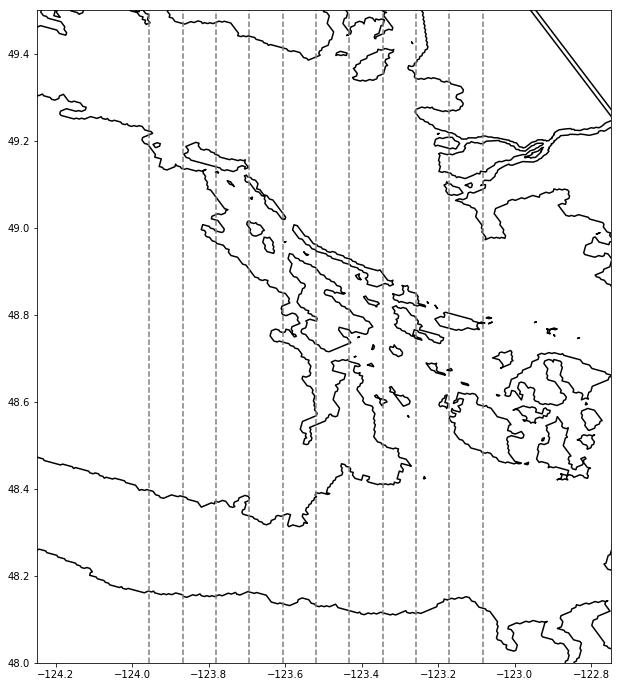

In [50]:
fig, ax = plt.subplots(figsize = (12,12))
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.set_aspect(ax, coords = 'map')
ax.set_xlim(-124.25, -122.75)
ax.set_ylim(48, 49.5)
for p in range(11):
    ax.plot((bounds[p], bounds[p]), (48, 49.5), '--', color = 'grey')

In [47]:
from matplotlib.colors import LogNorm

In [55]:
list_of_model_chl = list_of_model_chl[list_of_ferry_chl < 25]
list_of_lons = list_of_lons[list_of_ferry_chl < 25]
list_of_ferry_chl = list_of_ferry_chl[list_of_ferry_chl < 25]

bias =  0.808800271476
RMSE = 3.34652325855
Willmott = 0.595797999013


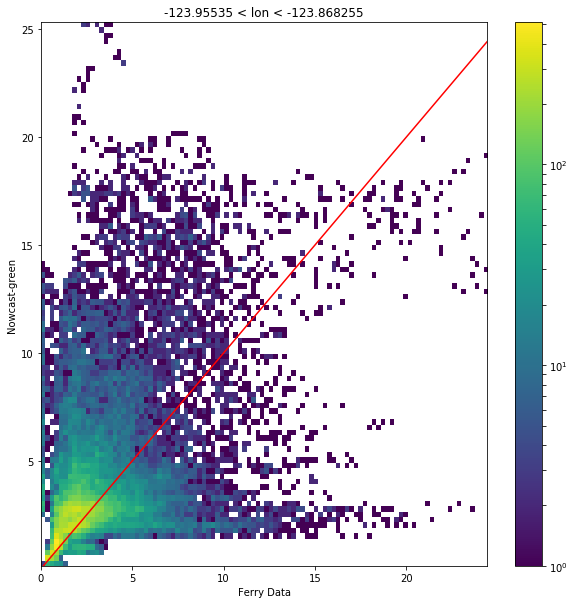

In [56]:
make_plot(0)

bias =  0.747782844077
RMSE = 2.92848152325
Willmott = 0.667410325308


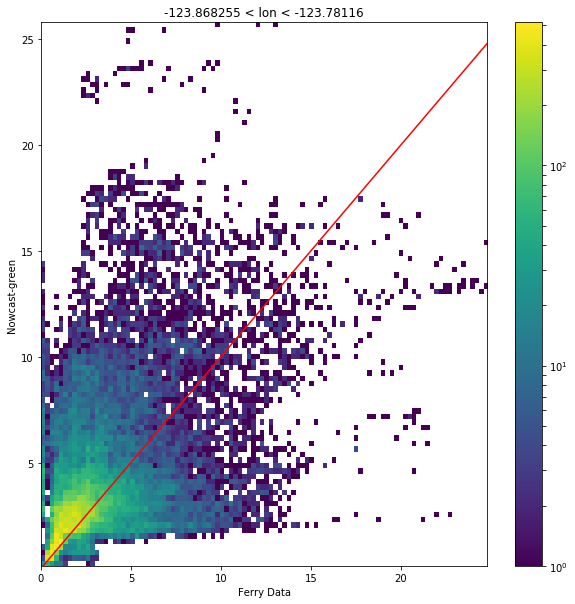

In [57]:
make_plot(1)

bias =  0.833956905775
RMSE = 2.94232943849
Willmott = 0.683796551854


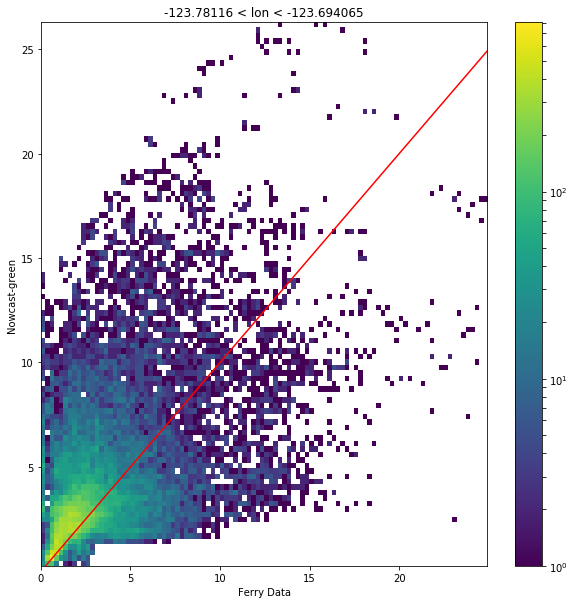

In [58]:
make_plot(2)

bias =  0.983748860883
RMSE = 3.19106038185
Willmott = 0.66794925301


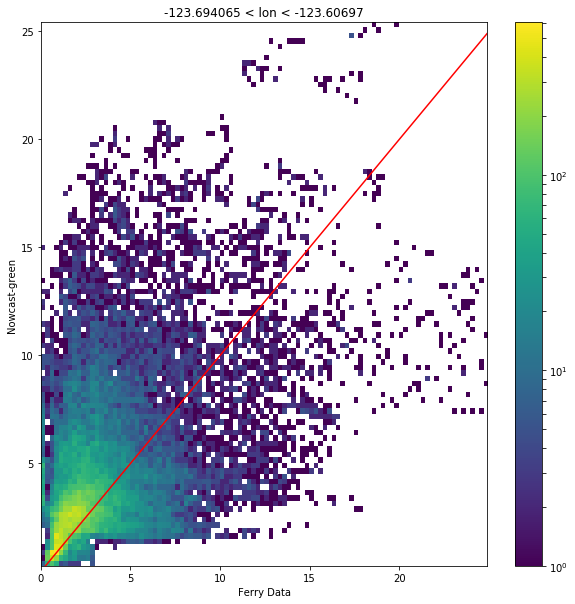

In [59]:
make_plot(3)

bias =  1.38851827536
RMSE = 3.60780998033
Willmott = 0.619404431285


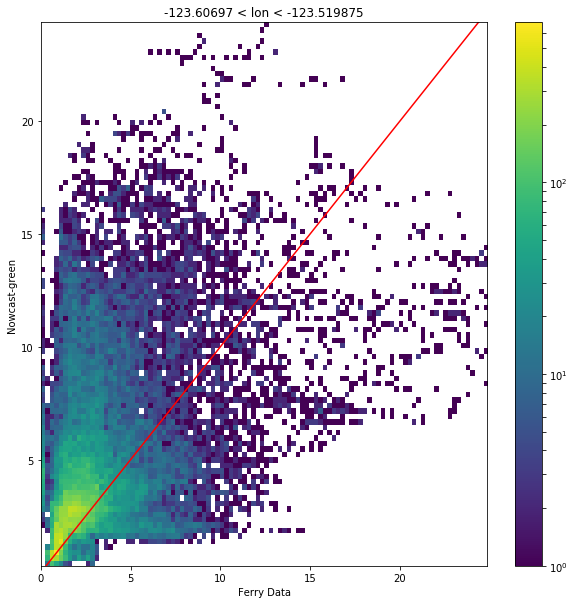

In [60]:
make_plot(4)

bias =  2.00650519473
RMSE = 4.11222688203
Willmott = 0.549347784454


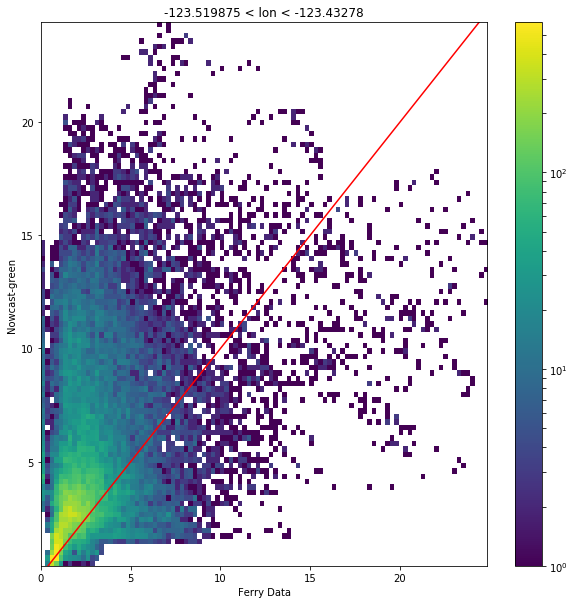

In [61]:
make_plot(5)

bias =  2.89531676993
RMSE = 4.83159755248
Willmott = 0.45911867192


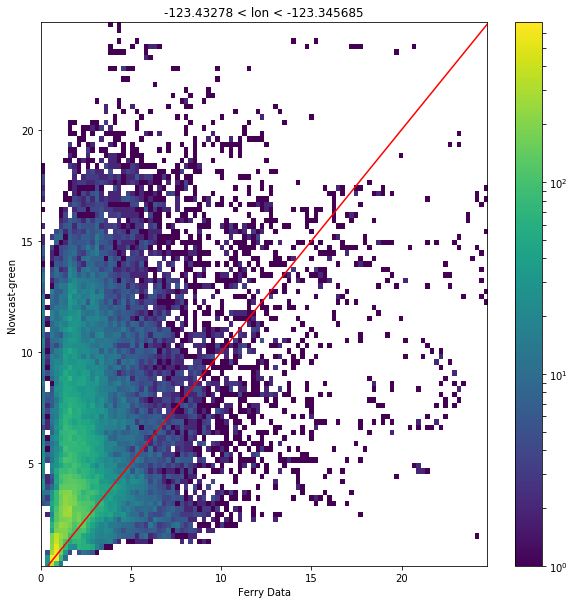

In [62]:
make_plot(6)

bias =  4.05549376586
RMSE = 5.87195741774
Willmott = 0.434143272544


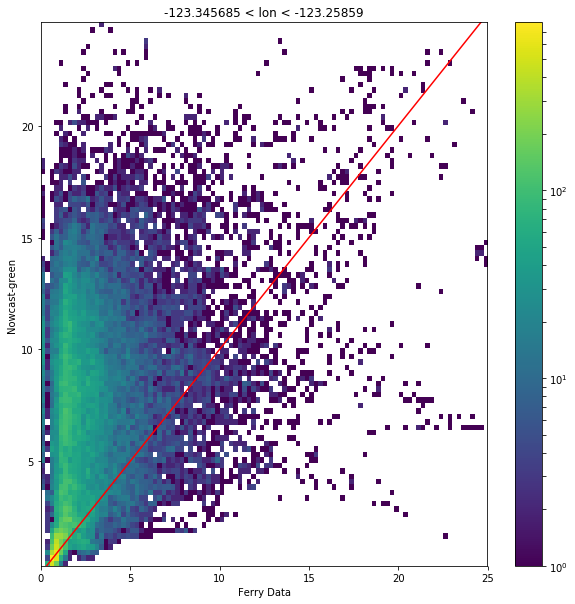

In [63]:
make_plot(7)

bias =  4.80471372577
RMSE = 6.54125434979
Willmott = 0.415214430901


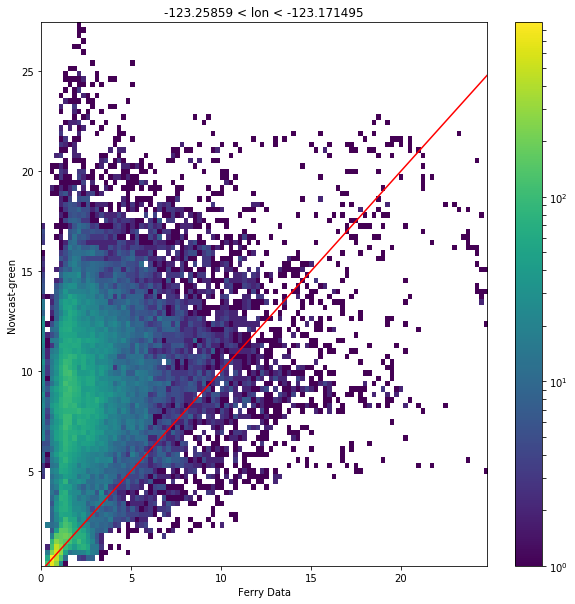

In [64]:
make_plot(8)

bias =  4.71446279593
RMSE = 6.3615964614
Willmott = 0.419380252416


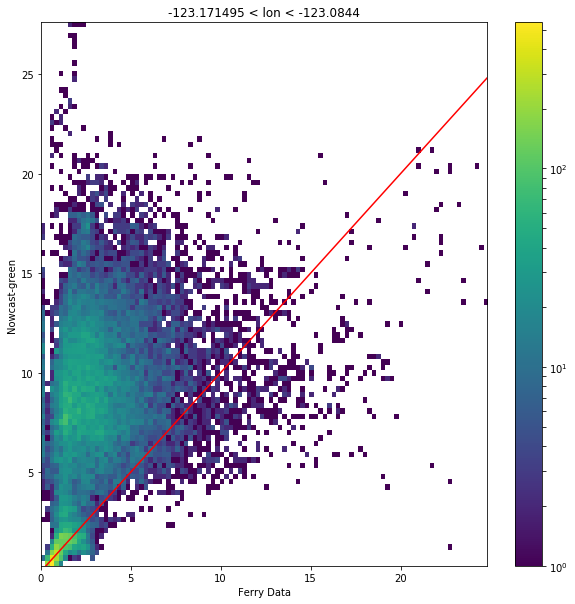

In [65]:
make_plot(9)

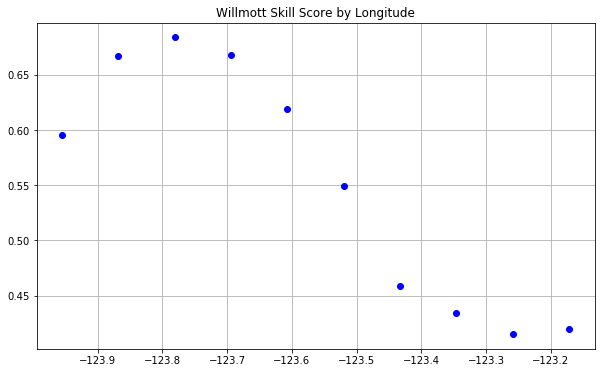

In [69]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(bounds[:-1], [0.595797999013,0.667410325308,0.683796551854,0.66794925301,0.619404431285,
                      0.549347784454,0.45911867192,0.434143272544,0.415214430901,0.419380252416], 'bo')
ax.grid('on')
ax.set_title('Willmott Skill Score by Longitude')